In [1]:
#參考資料 https://www.kaggle.com/outrunner/use-keras-to-count-sea-lions
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
r = 0.4     #scale down
width = 100 #patch size 

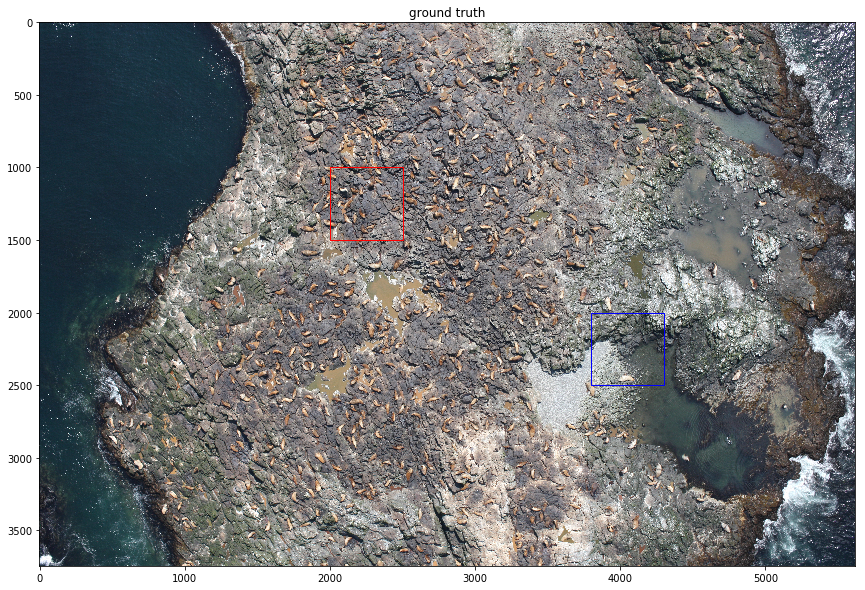

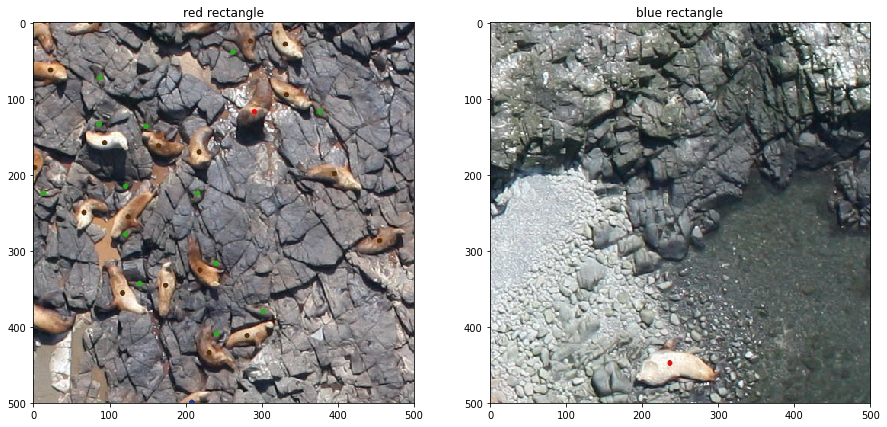

In [40]:
import matplotlib.patches as patches
filename = '0.jpg'
image_1 = cv2.imread("../corpus/KaggleNOAASeaLions/TrainDotted/" + filename)
image_2 = cv2.imread("../corpus/KaggleNOAASeaLions/Train/" + filename)    
img1 = cv2.GaussianBlur(image_1,(5,5),0)

xy_red   = [2000,1000,500]
xy_blue  = [3800,2000,500]

plt.figure(figsize=(15, 10))
ax = plt.subplot(1,1,1)
ax.set_title('ground truth')
#ax.imshow(image_2)
ax.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
rec_red  = patches.Rectangle((xy_red[0],xy_red[1]),xy_red[2],xy_red[2],linewidth=1,edgecolor='r',facecolor='none')
rec_blue = patches.Rectangle((xy_blue[0],xy_blue[1]),xy_blue[2],xy_blue[2],linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rec_red)
ax.add_patch(rec_blue)

plt.figure(figsize=(15, 10))
ax = plt.subplot(1,2,1)
ax.set_title('red rectangle')
img_red = image_1[xy_red[1]:xy_red[1]+xy_red[2],xy_red[0]:xy_red[0]+xy_red[2],:]
ax.imshow(cv2.cvtColor(img_red,cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
ax.set_title('blue rectangle')
img_red = image_1[xy_blue[1]:xy_blue[1]+xy_blue[2],xy_blue[0]:xy_blue[0]+xy_blue[2],:]
ax.imshow(cv2.cvtColor(img_red,cv2.COLOR_BGR2RGB))


# label mark
  * <font color='red'>red</font>: adult males
  * <font color='magenta'>magenta</font>: subadult males
  * <font color='brown'>brown</font>: adult females
  * <font color='blue'>blue</font>: juveniles
  * <font color='green'>green</font>: pups

# dataset description
  
  
  <font size =3 >
  <table align="left" border="2" >
  <tr> <td></td>                                       <td><font size=3>number</font></td><td><font size=3>size</font></td></tr>
  <tr> <td><font size = 3>training data</font></td>    <td><font size=3>949   </font></td><td><font size=3>5.86GB</font></td></tr>
  <tr> <td><font size = 3>training data dot</font></td><td><font size=3>948   </font></td><td><font size=3>3.95GB</font></td></tr>
  <tr> <td><font size = 3>testing data</font></td>     <td><font size=3>18636 </font></td><td><font size=3>86GB</font></td></tr>
  </table>
  </font>

In [13]:
# absolute difference between Train and Train Dotted
image_3 = cv2.absdiff(image_1,image_2)
mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
mask_1[mask_1 < 50] = 0
mask_1[mask_1 > 0] = 255
image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
# convert to grayscale to be accepted by skimage.feature.blob_log
image_6 = np.max(image_4,axis=2)


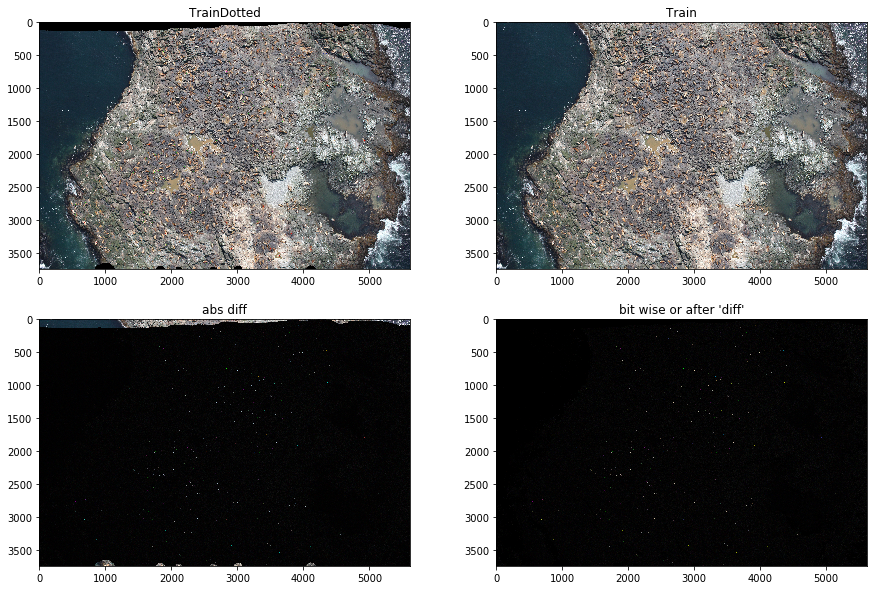

In [42]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(2,2,1); ax.imshow(cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)); ax.set_title('TrainDotted')
ax = plt.subplot(2,2,2); ax.imshow(cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB)); ax.set_title('Train')
ax = plt.subplot(2,2,3); ax.imshow(cv2.cvtColor(image_3,cv2.COLOR_BGR2RGB)); ax.set_title('abs diff')
ax = plt.subplot(2,2,4); ax.imshow(image_4); ax.set_title('bit wise or after \'diff\'')

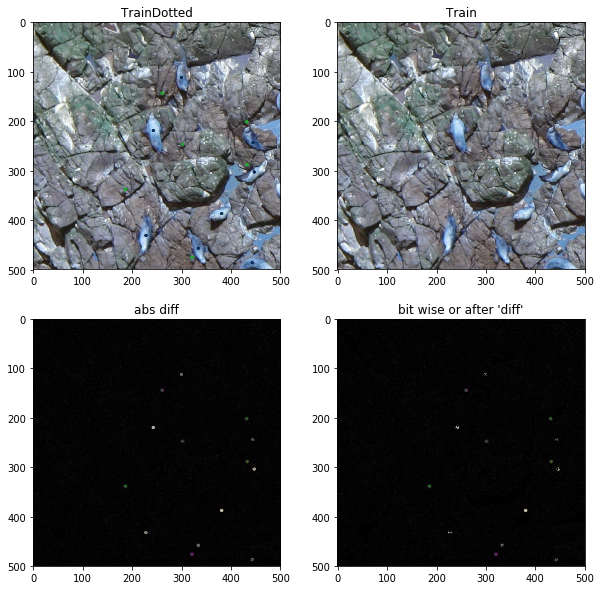

In [33]:
plt.figure(figsize=(10, 10))
xyw = [2000,1000,500]
ax = plt.subplot(2,2,1); ax.imshow(image_1[xyw[0]:xyw[0]+xyw[2],xyw[1]:xyw[1]+xyw[2],:]); ax.set_title('TrainDotted')
ax = plt.subplot(2,2,2); ax.imshow(image_2[xyw[0]:xyw[0]+xyw[2],xyw[1]:xyw[1]+xyw[2],:]); ax.set_title('Train')
ax = plt.subplot(2,2,3); ax.imshow(image_3[xyw[0]:xyw[0]+xyw[2],xyw[1]:xyw[1]+xyw[2],:]); ax.set_title('abs diff')
ax = plt.subplot(2,2,4); ax.imshow(image_4[xyw[0]:xyw[0]+xyw[2],xyw[1]:xyw[1]+xyw[2],:]); ax.set_title('bit wise or after \'diff\'')


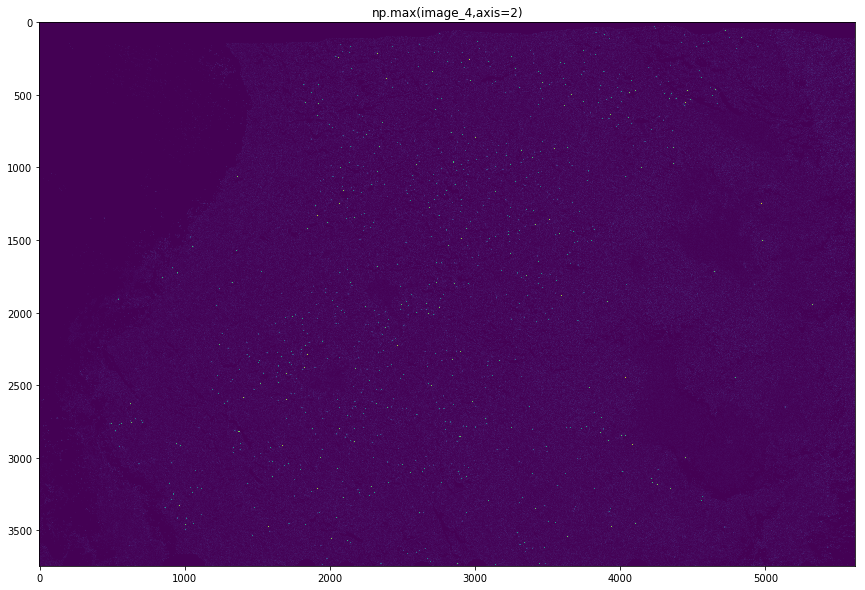

In [44]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(1,1,1)
ax.set_title('np.max(image_4,axis=2)')
ax.imshow(cv2.cvtColor(image_6,cv2.COLOR_BGR2RGB))
#ax.imshow(image_6)

In [ ]:



    # detect blobs
    blobs = skimage.feature.blob_log(image_6, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

    h,w,d = image_2.shape

    res=np.zeros((int((w*r)//width)+1,int((h*r)//width)+1,5), dtype='int16')

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        b,g,R = img1[int(y)][int(x)][:]
        x1 = int((x*r)//width)
        y1 = int((y*r)//width)
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if R > 225 and b < 25 and g < 25: # RED
            res[x1,y1,0]+=1
        elif R > 225 and b > 225 and g < 25: # MAGENTA
            res[x1,y1,1]+=1
        elif R < 75 and b < 50 and 150 < g < 200: # GREEN
            res[x1,y1,4]+=1
        elif R < 75 and  150 < b < 200 and g < 75: # BLUE
            res[x1,y1,3]+=1
        elif 60 < R < 120 and b < 50 and g < 75:  # BROWN
            res[x1,y1,2]+=1

    ma = cv2.cvtColor((1*(np.sum(image_1, axis=2)>20)).astype('uint8'), cv2.COLOR_GRAY2BGR)
    img = cv2.resize(image_2 * ma, (int(w*r),int(h*r)))
    h1,w1,d = img.shape

    trainX = []
    trainY = []

    for i in range(int(w1//width)):
        for j in range(int(h1//width)):
            trainY.append(res[i,j,:])
            trainX.append(img[j*width:j*width+width,i*width:i*width+width,:])

In [ ]:
print(np.random.seed(1004))

In [ ]:
randomize = np.arange(len(trainX))

In [ ]:
trainX, trainY = GetData("0.jpg")

np.random.seed(1004)
randomize = np.arange(len(trainX))
np.random.shuffle(randomize)
trainX = trainX[randomize]
trainY = trainY[randomize]

n_train = int(len(trainX) * 0.7)
testX = trainX[n_train:]
testY = trainY[n_train:]
trainX = trainX[:n_train]
trainY = trainY[:n_train]

print(trainY.shape, trainY[0])
print(testY.shape, testY[0])